In [1]:
# ─── Cell 1: Patch the mean warning and silence logging ───
import warnings, numpy as np, logging
from gluonts.model import forecast as _fm

# Silence the specific UserWarning
warnings.filterwarnings(
    "ignore",
    message=r"The mean prediction is not stored in the forecast data; the median is being returned instead\. This behaviour may change in the future\."
)
# Disable all WARNING and below from all loggers (including GluonTS internals)
logging.disable(logging.WARNING)

# Override .mean on the original classes (in-place)
def _silent_mean(self):
    fd = getattr(self, "_forecast_dict", {})
    if "mean" in fd:
        return fd["mean"]
    if hasattr(self, "samples"):
        return np.median(self.samples, axis=0)
    return self.quantile("p50")

_fm.SampleForecast.mean   = property(_silent_mean)
_fm.QuantileForecast.mean = property(_silent_mean)
# ────────────────────────────────────────────────────────────

In [2]:
# ─── Cell 2: Core imports ───
import torch
import time
import pandas as pd
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from local.gluonts.torch.model.tft import TemporalFusionTransformerEstimator


from pytorch_lightning.utilities.model_summary import ModelSummary
# ─────────────────────────

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

prediction_length = 24
context_length = 168
window_length = context_length + prediction_length
freq = "1h"

def get_electricity_dataset(csv_path: str, total_samples=500_000):
    df = pd.read_csv(csv_path, index_col=0)
    df["date"] = pd.to_datetime(df["date"])

    # Encode categorical ID
    label_encoder = LabelEncoder()
    df["categorical_id"] = label_encoder.fit_transform(df["categorical_id"].astype(str))

    # Limit data to Jan 1 – Sep 1, 2014 (i.e., days_from_start < 1339)
    full_range_df = df[df["days_from_start"] < 1339]

    # Sample sliding windows over full range
    def sample_windows(subset_df):
        samples = []
        for entity_id, group in subset_df.groupby("id"):
            group = group.sort_values("date")
            if len(group) < window_length:
                continue

            scaler = StandardScaler().fit(group[["power_usage", "hour", "day_of_week", "t"]].values)
            target_scaler = StandardScaler().fit(group[["power_usage"]].values)

            features = scaler.transform(group[["power_usage", "hour", "day_of_week", "t"]].values)
            targets = target_scaler.transform(group[["power_usage"]].values).flatten().astype(np.float32)

            feat_hour = features[:, 1].astype(np.float32)
            feat_dow = features[:, 2].astype(np.float32)
            feat_time = features[:, 3].astype(np.float32)

            static_cat = [group["categorical_id"].iloc[0]]
            dates = group["date"].values

            for i in range(0, len(group) - window_length + 1):
                samples.append({
                    FieldName.START: dates[i],
                    FieldName.TARGET: targets[i:i + window_length],
                    FieldName.FEAT_STATIC_CAT: static_cat,
                    FieldName.FEAT_DYNAMIC_REAL: [
                        feat_hour[i:i + window_length],
                        feat_dow[i:i + window_length],
                        feat_time[i:i + window_length],
                    ],
                })

        return samples

    # Step 1: All possible windows up to Sep 1
    all_samples = sample_windows(full_range_df)

    # Step 2: Shuffle and take 500,000 total
    np.random.shuffle(all_samples)
    all_samples = all_samples[:total_samples]

    # Step 3: Split into 450k train / 50k val
    train_samples = all_samples[:450_000]
    val_samples = all_samples[450_000:]

    # Step 4: Test set = fixed last 7 days (same as official code)
    test_df = df[df["days_from_start"] >= 1332]
    test_samples = sample_windows(test_df)

    train_ds = ListDataset(train_samples, freq=freq)
    val_ds = ListDataset(val_samples, freq=freq)
    test_ds = ListDataset(test_samples, freq=freq)

    return train_ds, val_ds, test_ds, freq, prediction_length


In [4]:
file_path = "../Dataset/Electricity/hourly_electricity.csv"  # Adjust if it's in a subfolder

In [5]:
train_ds, val_ds, test_ds, freq, prediction_length = get_electricity_dataset(file_path)

In [10]:
# Step 3: Define Estimator (PyTorch-based TFT)
# estimator = TemporalFusionTransformerEstimator(
#     freq=freq,
#     prediction_length=prediction_length,
#     context_length=168,
#     static_cardinalities=[370],
#     dynamic_dims=[3],
#     past_dynamic_dims=[],
#     quantiles=[0.1, 0.5, 0.9],
#     batch_size=128,
#     patience=5,
#     num_batches_per_epoch=50,  # Based on 500k / 64
#     trainer_kwargs={
#         "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
#         "max_epochs": 1,
#     }
# )

estimator = TemporalFusionTransformerEstimator(
    freq="1H",
    prediction_length=24,
    context_length=168,
    quantiles=[0.1, 0.5, 0.9],

    # Model architecture params (increased capacity)
    hidden_dim=160,                    # Matches original paper (d_model)
    num_heads=4,                      # Matches paper (must divide hidden_dim)
    dropout_rate=0.1,                 # Regularization from paper

    # Input dimensions
    static_cardinalities=[370],       # 370 categorical static features (electricity)
    dynamic_dims=[3],                 # Real-valued dynamic known features
    past_dynamic_dims=[],            # No past-only real-valued features

    # Training params
    batch_size=128,
    num_batches_per_epoch=3906,       # 500,000 / 128 for full data per epoch
    patience=5,
    lr=1e-3,
    weight_decay=1e-8,

    # Hardware config
    trainer_kwargs={
        "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
        "max_epochs": 10,             # Increase for better convergence
        "precision": "bf16-mixed",
    }
)


/home/akm9999/.local/lib/python3.9/site-packages/gluonts/time_feature/_base.py:249: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = to_offset(freq_str)


In [11]:
print("Training TFT model...")
print(f"Training samples: {len(list(train_ds))}")
print(f"Validation samples: {len(list(val_ds))}")

Training TFT model...
Training samples: 450000
Validation samples: 50000


In [12]:
module = estimator.create_lightning_module()
# max_depth = −1 will show **all** submodules
summary = ModelSummary(module, max_depth=1)
print(summary)

# ── 3) Time & memory for training ──
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
t0 = time.time()
predictor = estimator.train(
    training_data=train_ds,
    validation_data=val_ds
)
if torch.cuda.is_available():
    torch.cuda.synchronize()
    train_peak_mem = torch.cuda.max_memory_allocated() / (1024**2)
train_time = time.time() - t0
print(f"Training: {train_time:.3f}s, Peak GPU mem: {train_peak_mem:.1f} MB")

  | Name  | Type                           | Params | Mode  | In sizes                                                                                 | Out sizes                     
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0 | model | TemporalFusionTransformerModel | 858 K  | train | [[1, 168], [1, 168], [1, 1], [1, 1], [1, 192, 7], [1, 192, 0], [1, 168, 0], [1, 168, 0]] | [[[1, 24, 3]], [1, 1], [1, 1]]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
858 K     Trainable params
0         Non-trainable params
858 K     Total params
3.435     Total estimated model params size (MB)
250       Modules in train mode
0         Modules in eval mode


/home/akm9999/.local/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /share/apps/pyenv/py3.9/lib/python3.9/site-packages/ ...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training: 5644.253s, Peak GPU mem: 450.6 MB


In [13]:
# ── 2) AMP bfloat16 Inference ──
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
t1 = time.time()
# (keeps your existing precision setting)
with torch.amp.autocast("cuda"):
    f_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,
        predictor=predictor,
        num_samples=100,
    )
    forecasts = list(f_it)
    tss       = list(ts_it)
if torch.cuda.is_available():
    torch.cuda.synchronize()
    inf_peak_mem = torch.cuda.max_memory_allocated() / (1024**2)
inf_time = time.time() - t1
print(f"Inference: {inf_time:.3f}s, Peak GPU mem: {inf_peak_mem:.1f} MB")



Inference: 46.113s, Peak GPU mem: 193.6 MB


In [15]:
# ── 3) Evaluation timing (reuse FP32 outputs) ──
t2 = time.time()
evaluator    = Evaluator(quantiles=[0.5], num_workers=0)
agg_metrics, item_metrics = evaluator(tss, forecasts)
eval_time = time.time() - t2
print(f"Evaluation time: {eval_time:.3f}s")


Running evaluation: 0it [00:00, ?it/s]
Running evaluation: 3208it [00:10, 320.78it/s]
Running evaluation: 6418it [00:20, 320.87it/s]
Running evaluation: 9633it [00:30, 321.13it/s]
Running evaluation: 12848it [00:40, 321.07it/s]
Running evaluation: 16086it [00:50, 322.03it/s]
Running evaluation: 19324it [01:00, 321.83it/s]
Running evaluation: 22539it [01:10, 321.64it/s]
Running evaluation: 25761it [01:20, 321.81it/s]
Running evaluation: 28983it [01:30, 321.23it/s]
Running evaluation: 32193it [01:40, 321.14it/s]
Running evaluation: 35416it [01:50, 321.47it/s]
Running evaluation: 38639it [02:00, 321.11it/s]
Running evaluation: 41843it [02:10, 320.85it/s]
Running evaluation: 45086it [02:20, 321.88it/s]
Running evaluation: 48329it [02:30, 321.92it/s]
Running evaluation: 53505it [02:46, 321.57it/s]


Evaluation time: 166.760s


In [16]:
# Step 6: Print metrics
# print("Inference Time (s):", inference_time)
print("RMSE:", agg_metrics["RMSE"])
print("MASE:", agg_metrics["MASE"])
print("sMAPE:", agg_metrics["sMAPE"])

RMSE: 0.42422893398532396
MASE: 0.9562343002075506
sMAPE: 0.44440558510632744


In [17]:
import pandas as pd

# 1) Grab the first test entry & its forecast
test_entry     = next(iter(test_ds))
forecast_entry = forecasts[0]

# 2) Forecast diagnostics
print("→ Forecast start_date:", forecast_entry.start_date)
print("→ Forecast quantiles:", forecast_entry.forecast_keys)
median_fc = forecast_entry.quantile(0.5)
print("→ Median forecast length:", len(median_fc))

→ Forecast start_date: 2014-09-01 00:00
→ Forecast quantiles: ['0.1', '0.5', '0.9']
→ Median forecast length: 24


In [18]:
# first entry of the time series list
ts_entry = tss[0]

In [19]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(
    -1,
)

array([0.27276656, 0.0958369 , 0.0958369 , 0.27276656, 0.18430173],
      dtype=float32)

In [20]:
# first entry of dataset.test
dataset_test_entry = next(iter(test_ds))

In [21]:
# first 5 values
dataset_test_entry["target"][:5]

array([0.27276656, 0.0958369 , 0.0958369 , 0.27276656, 0.18430173],
      dtype=float32)

In [22]:
# first entry of the forecast list
forecast_entry = forecasts[0]
# print(f"Number of sample paths: {forecast_entry.num_samples}")
# print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Start date of the forecast window: 2014-09-01 00:00
Frequency of the time series: <Hour>


In [23]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [ 0.1327643   0.14122513  0.15522397  0.1598005   0.16549233  0.16687682
  0.24277434  0.03581086  0.03673385 -0.01495413 -0.0351063  -0.11694562
 -0.16340327 -0.23478192 -0.18924725 -0.18217093 -0.19109327 -0.1741716
 -0.14617392 -0.07633361 -0.02203046  0.11341976  0.20627739  0.21494493]
0.5-quantile (median) of the future window:
 [ 0.1327643   0.14122513  0.15522397  0.1598005   0.16549233  0.16687682
  0.24277434  0.03581086  0.03673385 -0.01495413 -0.0351063  -0.11694562
 -0.16340327 -0.23478192 -0.18924725 -0.18217093 -0.19109327 -0.1741716
 -0.14617392 -0.07633361 -0.02203046  0.11341976  0.20627739  0.21494493]


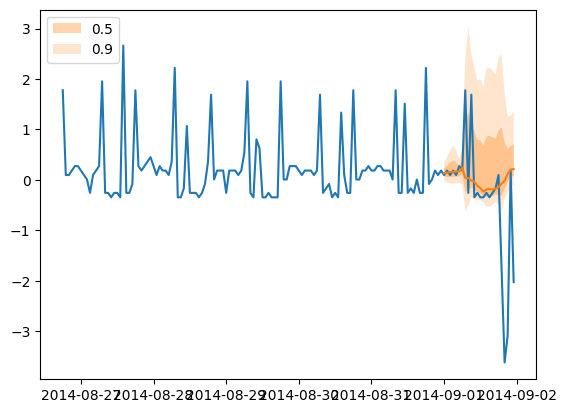

In [24]:
import matplotlib.pyplot as plt

plt.plot(ts_entry[-150:].to_timestamp())
forecast_entry.plot(show_label=True)
plt.legend()

In [25]:
import json
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.17997018843032433,
    "abs_error": 330189.42645436525,
    "abs_target_sum": 1115203.6304939985,
    "abs_target_mean": 0.8684574887814211,
    "seasonal_error": 0.32064557889547723,
    "MASE": 0.9562343002075506,
    "MAPE": 1.4928903389053125,
    "sMAPE": 0.44440558510632744,
    "MSIS": 8.82544466769796,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.5]": 330189.42645945563,
    "Coverage[0.5]": 0.5572602249010996,
    "RMSE": 0.42422893398532396,
    "NRMSE": 0.4884855499151514,
    "ND": 0.2960799421968365,
    "wQuantileLoss[0.5]": 0.296079942201401,
    "mean_absolute_QuantileLoss": 330189.42645945563,
    "mean_wQuantileLoss": 0.296079942201401,
    "MAE_Coverage": 0.05726022490109961,
    "OWA": NaN
}


In [26]:
item_metrics.head()

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,num_masked_target_values,ND,MSIS,QuantileLoss[0.5],Coverage[0.5]
0,None,2014-09-01 00:00,1.557088,16.180378,17.943615,0.747651,0.318228,2.118554,0.666518,0.961503,0.0,0.901735,53.278302,16.180377,0.708333
1,None,2014-09-01 01:00,2.089042,19.731445,21.290535,0.887106,0.318228,2.583508,0.713718,1.015935,0.0,0.926771,70.443186,19.731444,0.708333
2,None,2014-09-01 02:00,2.652023,23.452240,24.548990,1.022875,0.317613,3.076624,0.781904,1.103650,0.0,0.955324,88.142779,23.452238,0.791667
3,None,2014-09-01 03:00,3.175603,26.732718,27.807446,1.158644,0.317613,3.506979,0.750516,1.131149,0.0,0.961351,105.060185,26.732717,0.791667
4,None,2014-09-01 04:00,3.797855,30.604856,31.065899,1.294412,0.317613,4.014953,0.787963,1.221155,0.0,0.985159,123.063186,30.604857,0.791667


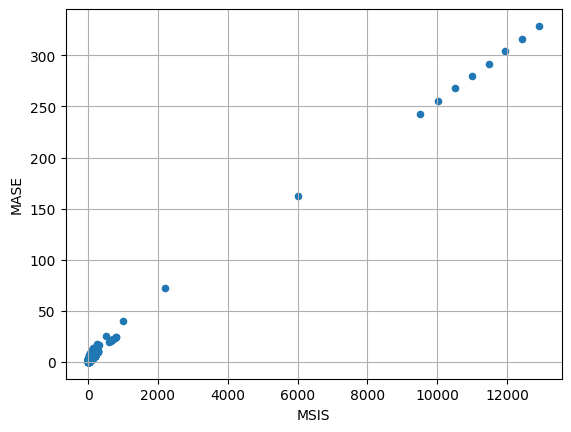

In [27]:
item_metrics.plot(x="MSIS", y="MASE", kind="scatter")
plt.grid(which="both")
plt.show()

In [28]:
from pathlib import Path
# 1) pick a folder and make sure it exists
save_dir = Path("saved_model_flash_updated")
save_dir.mkdir(parents=True, exist_ok=True)

# 2) save the full GluonTS Predictor
#    this will write a metadata.json and predictor.pkl inside saved_model/
predictor.serialize(save_dir)

# 3) (optional) save only the PyTorch TFT weights
torch.save(
    predictor.prediction_net.model.state_dict(),
    save_dir / "tft_flash_weights.pt"
)
